### Testing GA Hyperparameter Tuning

Dependencies:
```
numpy
pandas 
matplotlib
sklearn
```

In [167]:
from genetic_algorithm import GeneticAlgorithm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay



##### Load data 

In [126]:
def get_analytics(y_test, y_pred):
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred, average='weighted')
   recall = recall_score(y_test, y_pred, average='weighted')
   f1 = f1_score(y_test, y_pred, average='weighted')
   
   return accuracy, precision, recall, f1
   # cm = confusion_matrix(y_test, y_pred)
   # report = classification_report(y_test, y_pred, output_dict=True)
   # cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
   
   # print("Accuracy: ", accuracy)
   # print("Precision: ", precision)
   # print("Recall: ", recall)
   # print("F1 Score: ", f1)
   
   # print("Classification Report:")
   # print(report)
   # cm_display.plot(cmap=plt.cm.Blues)
   # plt.title("Confusion Matrix")
   # plt.show()
   
   

In [106]:
def prepare_data(X, y):
   # Splits and scales the data
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   y_train_binary = y_train # np.where(y_train > np.median(y_train), 1, 0)
   y_test_binary = y_test # np.where(y_test > np.median(y_train), 1, 0)
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)
   return X_train_scaled, X_test_scaled, y_train_binary, y_test_binary
   
   
   
   
   

In [107]:
# Load Diabetes Data 
from sklearn.datasets import load_diabetes, load_breast_cancer
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

X_train_scaled, X_test_scaled, y_train_binary, y_test_binary = prepare_data(X, y)




In [15]:
from sklearn.datasets import load_iris
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV

## Testing

For testing, 3 different models were used
- Decision Trees
- SVM
- Logistic Regression

4 Different Hyperparameter tuning methods were used
- Our Genetic Algorithm Hyperparameter Tuning Method 
- Grid Search
- Randomized Search
- Halving Grid Search

For each model, across all of the hyperparameter tuning methods, the same set of parameters was used for each one and the same parameters were used for each genetic algorithm

### Decision Tree

In [5]:
# Using the same params for Grid Search and Genetic Algorithm
# decision tree param space
param_space = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced'],
}

In [162]:
dt = DecisionTreeClassifier()

accuracies = []
precisions = []
recalls = []
f1s = []

ga_scores = []
ga_times = []
# Run Genetic Algorithm 10 times
for i in range(50):
    ga = GeneticAlgorithm(modelToTune=dt, 
                        param_space=param_space, 
                        verbose=0,
                        population_size=20,
                        generations=20,
                        mutation_prob=0.75,
                        crossover_prob=0.5,
                        cv=5,
                        scoring='accuracy'
                        ) 
    start = time.time()
    ga.run(X_train_scaled, y_train_binary)
    end = time.time()
    
    dt_test = DecisionTreeClassifier(**ga.best_params_)
    dt_test.fit(X_train_scaled, y_train_binary)
    y_pred = dt_test.predict(X_test_scaled)
    accuracy, precision, recall, f1 = get_analytics(y_test_binary, y_pred)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    # save score and time in a list
    ga_scores.append(ga.best_score_)
    ga_times.append(end - start)
    
# Print the average score and time
print('Genetic Algorithm with Decision Tree')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(ga_scores)}")
print(f"Average time (train): {np.mean(ga_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 score (test): {np.mean(f1s)}")

Genetic Algorithm with Decision Tree
--------------------------------------------------
Average score (train): 0.9526593406593407
Average time (train): 3.643609299659729 seconds

Average accuracy (test): 0.9442105263157893
Average precision (test): 0.9450408978929241
Average recall (test): 0.9442105263157893
Average f1 score (test): 0.9440391871868326


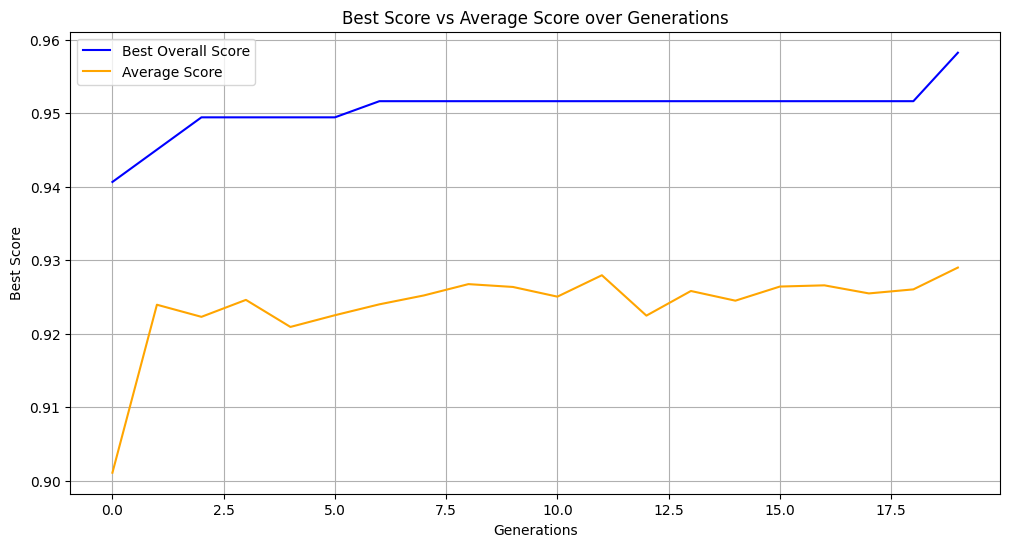

In [139]:
# Creating a graph of best scores over time 
ga_scores = ga.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [22]:
dt2 = DecisionTreeClassifier()

grid = GridSearchCV(dt2, param_space, cv=5, n_jobs=-1, scoring='accuracy')
start2 = time.time()
grid.fit(X_train_scaled, y_train_binary)
end2 = time.time()
print(f"Grid Search took {end2 - start2:.2f} seconds")
print(f"Best parameters from Grid Search: {grid.best_params_}")
print(f"Best score from Grid Search: {grid.best_score_:.4f}")

Grid Search took 1220.16 seconds
Best parameters from Grid Search: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 18, 'min_samples_split': 2, 'splitter': 'random'}
Best score from Grid Search: 0.7677


In [141]:
dt2 = grid.best_estimator_
y_pred2 = dt2.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred2)

ValueError: X has 30 features, but DecisionTreeClassifier is expecting 10 features as input.

In [25]:
print(grid.best_score_)

0.7677263581488933


##### Randomized Search

In [163]:
dt3 = DecisionTreeClassifier()

accuracies = []
precisions = []
recalls = []
f1s = []

dt3_best_times = []
dt3_best_scores = []
for i in range(50):
    rand = RandomizedSearchCV(dt3, param_space, n_iter=400, cv=5, n_jobs=-1, scoring='accuracy')
    start3 = time.time()
    rand.fit(X_train_scaled, y_train_binary)
    end3 = time.time()
    # save score and time in a list
    dt3_best_scores.append(rand.best_score_)
    dt3_best_times.append(end3 - start3)
    
    dt3_test = rand.best_estimator_
    y_pred3 = dt3_test.predict(X_test_scaled)
    acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred3)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    
# Print the average score and time
print('Randomized Search with Decision Tree')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(dt3_best_scores)}")
print(f"Average time (train): {np.mean(dt3_best_times)} seconds")   
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")
    
    



Randomized Search with Decision Tree
--------------------------------------------------
Average score (train): 0.9494945054945053
Average time (train): 0.5830179309844971 seconds

Average accuracy (test): 0.947719298245614
Average precision (test): 0.9486063796354028
Average recall (test): 0.947719298245614
Average f1 (test): 0.947670550106654


In [130]:
accuracies = []
precisions = []
recalls = []
f1s = []

for i in range(10):
    dt3 = rand.best_estimator_
    y_pred3 = dt3.predict(X_test_scaled)
    acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    
print(accuracies)
print(precisions)
print(recalls)
print(f1s)
print(f"Average accuracy from Randomized Search: {np.mean(accuracies)}")
print(f"Average precision from Randomized Search: {np.mean(precisions)}")
print(f"Average recall from Randomized Search: {np.mean(recalls)}")
print(f"Average f1 from Randomized Search: {np.mean(f1s)}")

[0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702]
[0.938457254246728, 0.938457254246728, 0.938457254246728, 0.938457254246728, 0.938457254246728, 0.938457254246728, 0.938457254246728, 0.938457254246728, 0.938457254246728, 0.938457254246728]
[0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702, 0.9385964912280702]
[0.9384499917007656, 0.9384499917007656, 0.9384499917007656, 0.9384499917007656, 0.9384499917007656, 0.9384499917007656, 0.9384499917007656, 0.9384499917007656, 0.9384499917007656, 0.9384499917007656]
Average accuracy from Randomized Search: 0.9385964912280702
Average precision from Randomized Search: 0.938457254246728
Average recall from Randomized Search: 0.9385964912280702
Average f1 from Randomized S

##### Halving Grid Search

In [28]:
dt4 = DecisionTreeClassifier()
start4 = time.time()
halving_grid = HalvingGridSearchCV(dt4, param_space, cv=5, n_jobs=-1, scoring='accuracy')
halving_grid.fit(X_train_scaled, y_train_binary)
end4 = time.time()
print(f"Halving Grid Search took {end4 - start4:.2f} seconds")
print(f"Best parameters from Halving Grid Search: {halving_grid.best_params_}")
print(f"Best score from Halving Grid Search: {halving_grid.best_score_}")


Halving Grid Search took 2153.46 seconds
Best parameters from Halving Grid Search: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.7, 'max_leaf_nodes': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'splitter': 'best'}
Best score from Halving Grid Search: 0.825873015873016


Accuracy:  0.7415730337078652
Precision:  0.7475598683463853
Recall:  0.7415730337078652
F1 Score:  0.7422268653746384
Classification Report:
{'0': {'precision': 0.7954545454545454, 'recall': 0.7142857142857143, 'f1-score': 0.7526881720430108, 'support': 49.0}, '1': {'precision': 0.6888888888888889, 'recall': 0.775, 'f1-score': 0.7294117647058823, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7421717171717171, 'recall': 0.7446428571428572, 'f1-score': 0.7410499683744465, 'support': 89.0}, 'weighted avg': {'precision': 0.7475598683463853, 'recall': 0.7415730337078652, 'f1-score': 0.7422268653746384, 'support': 89.0}}


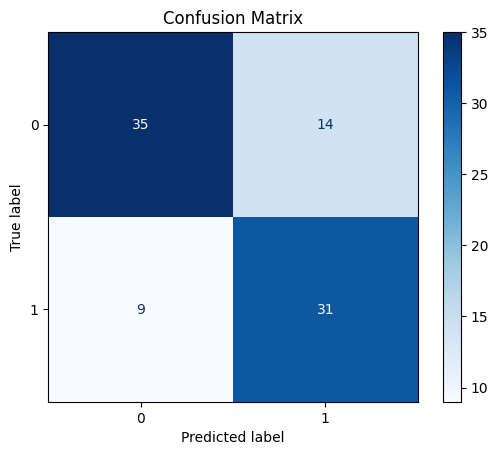

In [31]:
dt4 = halving_grid.best_estimator_
y_pred4 = dt4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)

### Random Forest

In [169]:
# large param grid for search 
param_space = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'n_estimators': range(50, 200, 50),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'class_weight': [None, 'balanced'],
}

##### Genetic Algorithm

In [ ]:
rf1 = RandomForestClassifier()

accuracies = []
precisions = []
recalls = []
f1s = []

rf1_scores = []
rf1_times = []

for i in range(25):
    ga = GeneticAlgorithm(modelToTune=rf1, 
                        param_space=param_space, 
                        verbose=0,
                        population_size=20,
                        generations=20,
                        mutation_prob=0.75,
                        crossover_prob=0.5,
                        cv=5,
                        scoring='accuracy'
                        )
    start = time.time()
    ga.run(X_train_scaled, y_train_binary)
    end = time.time()
    
    rf1_test = RandomForestClassifier(**ga.best_params_)
    rf1_test.fit(X_train_scaled, y_train_binary)
    y_pred = rf1_test.predict(X_test_scaled)
    accuracy, precision, recall, f1 = get_analytics(y_test_binary, y_pred)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    rf1_scores.append(ga.best_score_)
    rf1_times.append(end - start)
    
# Print the average score and time
print('Genetic Algorithm with Random Forest')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(rf1_scores)}")
print(f"Average time (train): {np.mean(rf1_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 score (test): {np.mean(f1s)}")

Generation 1/20 - Best: 0.9626 - Avg: 0.9403
Generation 2/20 - Best: 0.9692 - Avg: 0.9596
Generation 3/20 - Best: 0.9692 - Avg: 0.9598
Generation 4/20 - Best: 0.9692 - Avg: 0.9595


KeyboardInterrupt: 

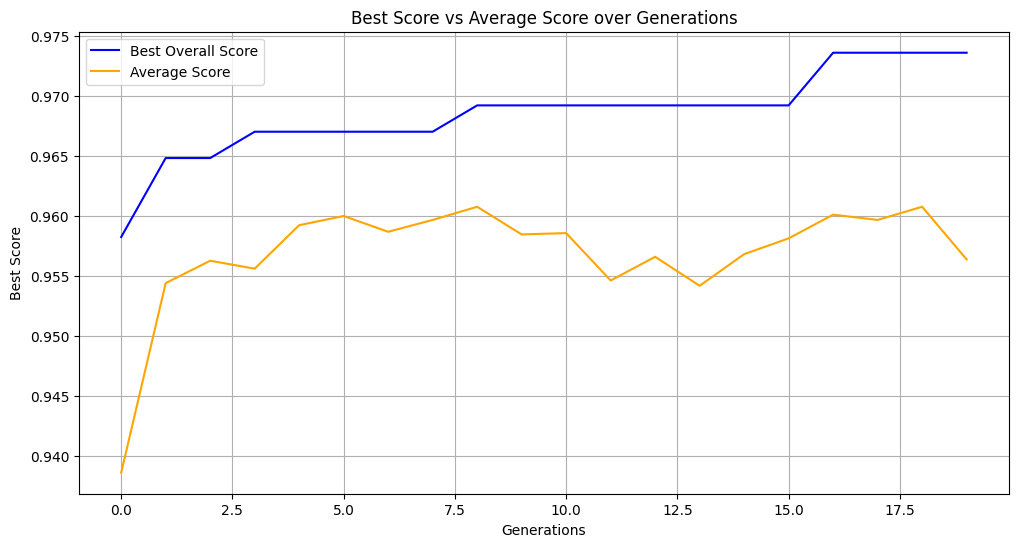

In [172]:
# Creating a graph of best scores over time 
ga_scores = ga.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [ ]:
rf2 = RandomForestClassifier()
grid = GridSearchCV(rf2, param_space, cv=5, n_jobs=-1, scoring='accuracy')
start2 = time.time()
grid.fit(X_train_scaled, y_train_binary)
end2 = time.time()
print(f"Grid Search took {end2 - start2:.2f} seconds")
print(f"Best parameters from Grid Search: {grid.best_params_}")
print(f"Best score from Grid Search: {grid.best_score_:.4f}")
rf2 = grid.best_estimator_
y_pred2 = rf2.predict(X_test_scaled)
acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred2)
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")

##### Randomized Search

In [ ]:
rf3 = RandomForestClassifier()

accuracies = []
precisions = []
recalls = []
f1s = []

ga_scores = []
ga_times = []

for i in range(25):
    rand = RandomizedSearchCV(rf3, param_space, n_iter=400, cv=5, n_jobs=-1, scoring='accuracy')
    start = time.time()
    rand.fit(X_train_scaled, y_train_binary)
    end = time.time()
    # save score and time in a list
    ga_scores.append(rand.best_score_)
    ga_times.append(end - start)
    
    rf3_test = rand.best_estimator_
    y_pred3 = rf3_test.predict(X_test_scaled)
    acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred3)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    
# Print the average score and time
print('Randomized Search with Random Forest')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(ga_scores)}")
print(f"Average time (train): {np.mean(ga_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")


Randomized Search with Random Forest
--------------------------------------------------
Average score (train): 0.9648351648351647
Average time (train): 35.42598819732666 seconds

Average accuracy (test): 0.9649122807017544
Average precision (test): 0.9652053622194477
Average recall (test): 0.9649122807017544
Average f1 (test): 0.9647382344750765


### Support Vector Machine

In [33]:
from sklearn.svm import SVC

In [35]:
svm_param_space = {
    'C': list(np.logspace(-5, 3, 15)), 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': range(2, 10),  
    'coef0': list(np.linspace(0, 1, 5)), 
    'shrinking': [True, False], 
    'tol': list(np.logspace(-5, -1, 5))  
}

##### Genetic Algorithm Search

In [ ]:
svm1 = SVC()

accuracies = []
precisions = []
recalls = []
f1s = []

ga_scores = []
ga_times = []

for i in range(50):
    ga_svm = GeneticAlgorithm(modelToTune=svm1,
                            param_space=svm_param_space,
                            verbose=0,
                            population_size=20,
                            generations=20,
                            mutation_prob=0.75,
                            crossover_prob=0.5,
                            cv=5,
                            scoring='accuracy'
                            )
    start5 = time.time()
    ga_svm.run(X_train_scaled, y_train_binary)
    end5 = time.time()
    
    svm1_test = SVC(**ga_svm.best_params_)
    svm1_test.fit(X_train_scaled, y_train_binary)
    y_pred5 = svm1_test.predict(X_test_scaled)
    accuracy, precision, recall, f1 = get_analytics(y_test_binary, y_pred5)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    # save score and time in a list
    ga_scores.append(ga_svm.best_score_)
    ga_times.append(end5 - start5)
    
# Print the average score and time
print('Genetic Algorithm with SVM')
print('--------------------------------------------------')
print(f"Average score from Genetic Algorithm (train): {np.mean(ga_scores)}")
print(f"Average time from Genetic Algorithm (train): {np.mean(ga_times)} seconds")
print('')
# Print the average accuracy, precision, recall, and f1 score
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 score (test): {np.mean(f1s)}")

                           

Genetic Algorithm with SVM
--------------------------------------------------
Average score from Genetic Algorithm (train): 0.9785494505494506
Average time from Genetic Algorithm (train): 1.7761718606948853 seconds

Average accuracy (test): 0.9801754385964913
Average precision (test): 0.9805724802181183
Average recall (test): 0.9801754385964913
Average f1 score (test): 0.9800977051495144


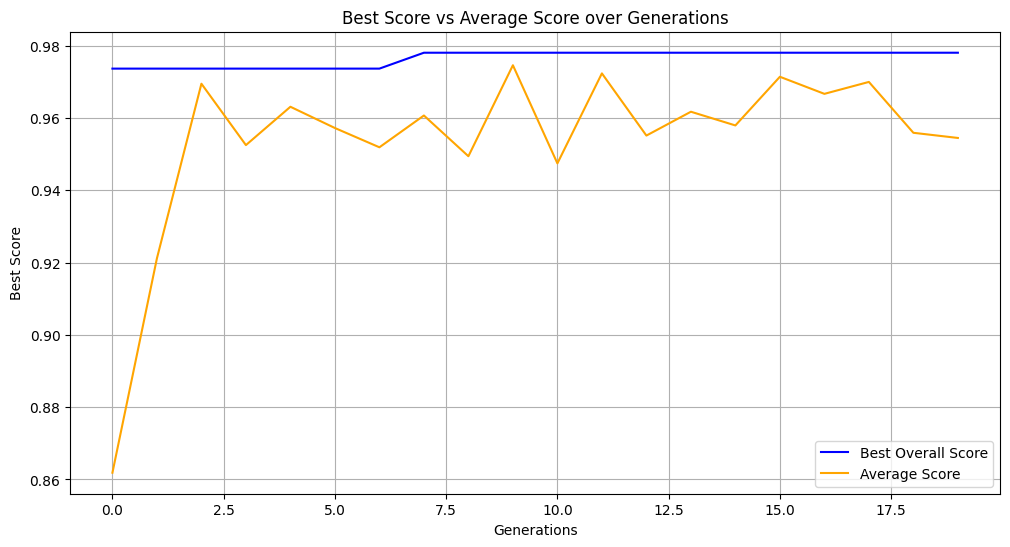

In [143]:
# Creating a graph of best scores over time 
ga_scores = ga_svm.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [40]:
svm2 = SVC()
grid_svm = GridSearchCV(svm2, svm_param_space, cv=5, n_jobs=-1, scoring='accuracy')
start6 = time.time()
grid_svm.fit(X_train_scaled, y_train_binary)
end6 = time.time()
print(f"Grid Search for SVM took {end6 - start6:.2f} seconds")
print(f"Best parameters from Grid Search for SVM: {grid_svm.best_params_}")
print(f"Best score from Grid Search for SVM: {grid_svm.best_score_}")


Grid Search for SVM took 940.42 seconds
Best parameters from Grid Search for SVM: {'C': np.float64(0.007196856730011514), 'coef0': np.float64(0.0), 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True, 'tol': np.float64(0.1)}
Best score from Grid Search for SVM: 0.7590744466800805


Accuracy:  0.7415730337078652
Precision:  0.740889766170665
Recall:  0.7415730337078652
F1 Score:  0.7403767664085832
Classification Report:
{'0': {'precision': 0.75, 'recall': 0.7959183673469388, 'f1-score': 0.7722772277227723, 'support': 49.0}, '1': {'precision': 0.7297297297297297, 'recall': 0.675, 'f1-score': 0.7012987012987013, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7398648648648649, 'recall': 0.7354591836734694, 'f1-score': 0.7367879645107368, 'support': 89.0}, 'weighted avg': {'precision': 0.740889766170665, 'recall': 0.7415730337078652, 'f1-score': 0.7403767664085832, 'support': 89.0}}


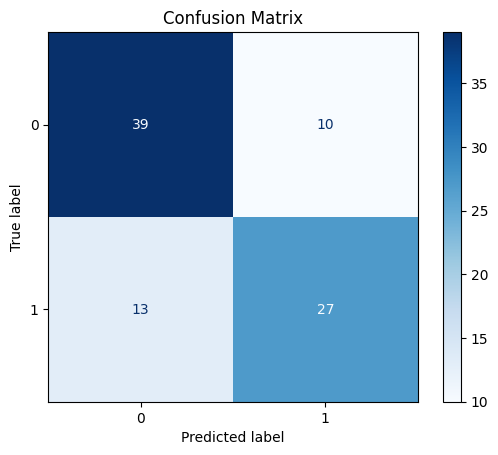

In [41]:
svm2 = grid_svm.best_estimator_
y_pred2 = svm2.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred2)

##### Randomized Search

In [ ]:
svm3 = SVC()

accuracies = []
precisions = []
recalls = []
f1s = []

svm3_best_times = []
svm3_best_scores = []

for i in range(50):
    rand_svm = RandomizedSearchCV(svm3, svm_param_space, n_iter=400, cv=5, n_jobs=-1, scoring='accuracy')
    start7 = time.time()
    rand_svm.fit(X_train_scaled, y_train_binary)
    end7 = time.time()
    # save score and time in a list
    svm3_best_scores.append(rand_svm.best_score_)
    svm3_best_times.append(end7 - start7)
    svm3_test = rand_svm.best_estimator_
    y_pred3 = svm3_test.predict(X_test_scaled)
    acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred3)
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
# Print the average score and time
print('Randomized Search with SVM')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(svm3_best_scores)}")
print(f"Average time (train): {np.mean(svm3_best_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")


Randomized Search with SVM
--------------------------------------------------
Average score (train): 0.9787692307692307
Average time (train): 0.5995930910110474 seconds

Average accuracy (test): 0.9791228070175438
Average precision (test): 0.9794751433377965
Average recall (test): 0.9791228070175438
Average f1 (test): 0.9790488489838336


Accuracy:  0.7415730337078652
Precision:  0.740889766170665
Recall:  0.7415730337078652
F1 Score:  0.7403767664085832
Classification Report:
{'0': {'precision': 0.75, 'recall': 0.7959183673469388, 'f1-score': 0.7722772277227723, 'support': 49.0}, '1': {'precision': 0.7297297297297297, 'recall': 0.675, 'f1-score': 0.7012987012987013, 'support': 40.0}, 'accuracy': 0.7415730337078652, 'macro avg': {'precision': 0.7398648648648649, 'recall': 0.7354591836734694, 'f1-score': 0.7367879645107368, 'support': 89.0}, 'weighted avg': {'precision': 0.740889766170665, 'recall': 0.7415730337078652, 'f1-score': 0.7403767664085832, 'support': 89.0}}


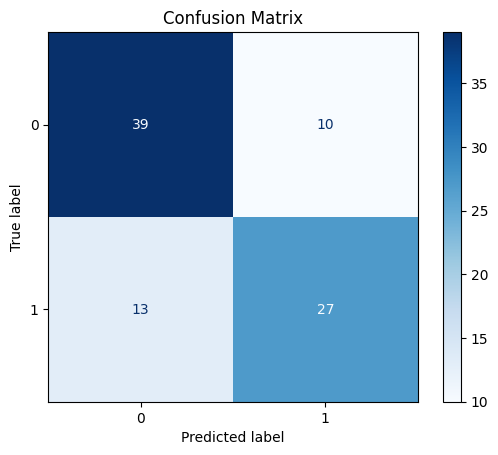

In [101]:
svm3 = rand_svm.best_estimator_
y_pred3 = svm3.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred3)

##### Halving Grid Search

In [44]:
svm4 = SVC()
halving_grid_svm = HalvingGridSearchCV(svm4, svm_param_space, cv=5, n_jobs=-1, scoring='accuracy')
start8 = time.time()
halving_grid_svm.fit(X_train_scaled, y_train_binary)
end8 = time.time()
print(f"Halving Grid Search for SVM took {end8 - start8:.2f} seconds")
print(f"Best parameters from Halving Grid Search for SVM: {halving_grid_svm.best_params_}")
print(f"Best score from Halving Grid Search for SVM: {halving_grid_svm.best_score_}")

Halving Grid Search for SVM took 194.74 seconds
Best parameters from Halving Grid Search for SVM: {'C': np.float64(1.389495494373136), 'coef0': np.float64(0.25), 'degree': 6, 'gamma': 'auto', 'kernel': 'sigmoid', 'shrinking': True, 'tol': np.float64(0.001)}
Best score from Halving Grid Search for SVM: 0.7582539682539682


Accuracy:  0.6853932584269663
Precision:  0.6843148850314816
Recall:  0.6853932584269663
F1 Score:  0.6845059060789398
Classification Report:
{'0': {'precision': 0.7058823529411765, 'recall': 0.7346938775510204, 'f1-score': 0.72, 'support': 49.0}, '1': {'precision': 0.6578947368421053, 'recall': 0.625, 'f1-score': 0.6410256410256411, 'support': 40.0}, 'accuracy': 0.6853932584269663, 'macro avg': {'precision': 0.681888544891641, 'recall': 0.6798469387755102, 'f1-score': 0.6805128205128206, 'support': 89.0}, 'weighted avg': {'precision': 0.6843148850314816, 'recall': 0.6853932584269663, 'f1-score': 0.6845059060789398, 'support': 89.0}}


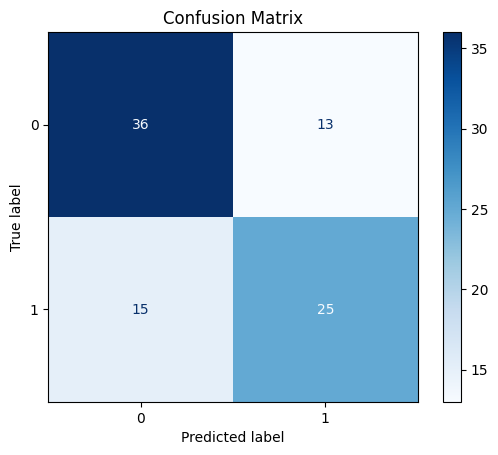

In [45]:
svm4 = halving_grid_svm.best_estimator_
y_pred4 = svm4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)

### Logistic Regression

Note: L1 penalty is not compatible with the GridSearchCV

In [46]:
from sklearn.linear_model import LogisticRegression
from genetic_algorithm import logGA

In [47]:
logreg_param_space = {
    'C': list(np.logspace(-4, 4, 20)),
    'penalty': ['l1', 'l2'],
    'solver': {  
        'l1': ['liblinear', 'saga'],
        'l2': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
    },
    'max_iter': list(range(100, 2001, 100)),
    'tol': [1e-4, 1e-5, 1e-6],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]
}

# Traditional searches only compatible with l2 penalty
logreg_param_space2 = {
    'C': list(np.logspace(-4, 4, 20)),
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear'],
    'max_iter': list(range(100, 2001, 100)),
    'tol': [1e-4, 1e-5, 1e-6],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]
}


##### Genetic Algorithm Search

In [ ]:
lr1 = LogisticRegression()

accuracies = []
precisions = []
recalls = []
f1s = []

lr1_best_times = []
lr1_best_scores = []

for i in range(50):
      ga_logreg = GeneticAlgorithm(
            modelToTune=lr1,
            param_space=logreg_param_space2,
            verbose=0,
            population_size=20,
            generations=20,
            mutation_prob=0.75,
            crossover_prob=0.5,
            cv=5,
            scoring='accuracy'
      )
      start9 = time.time()
      ga_logreg.run(X_train_scaled, y_train_binary)
      end9 = time.time()
      
      # save score and time in a list
      lr1_best_scores.append(ga_logreg.best_score_)
      lr1_best_times.append(end9 - start9)
      
      lr1_test = LogisticRegression(**ga_logreg.best_params_)
      lr1_test.fit(X_train_scaled, y_train_binary)
      y_pred = lr1_test.predict(X_test_scaled)
      
      accuracy, precision, recall, f1 = get_analytics(y_test_binary, y_pred)
      accuracies.append(accuracy)
      precisions.append(precision)
      recalls.append(recall)
      f1s.append(f1)

# Print the average score and time
print('Genetic Algorithm with Logistic Regression')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(lr1_best_scores)}")
print(f"Average time (train): {np.mean(lr1_best_times)} seconds")   
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")
    


/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Genetic Algorithm with Logistic Regression
--------------------------------------------------
Average score (train): 0.9780219780219781
Average time (train): 9.940802636146545 seconds

Average accuracy (test): 0.9791228070175438
Average precision (test): 0.9792269818705744
Average recall (test): 0.9791228070175438
Average f1 (test): 0.9791290138794981


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


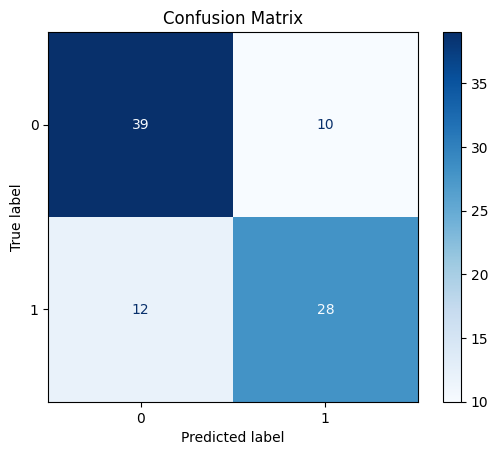

In [103]:
params = ga_logreg.best_params_
logreg_clf = LogisticRegression(**params).fit(X_train_scaled, y_train_binary)
y_pred = logreg_clf.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred)

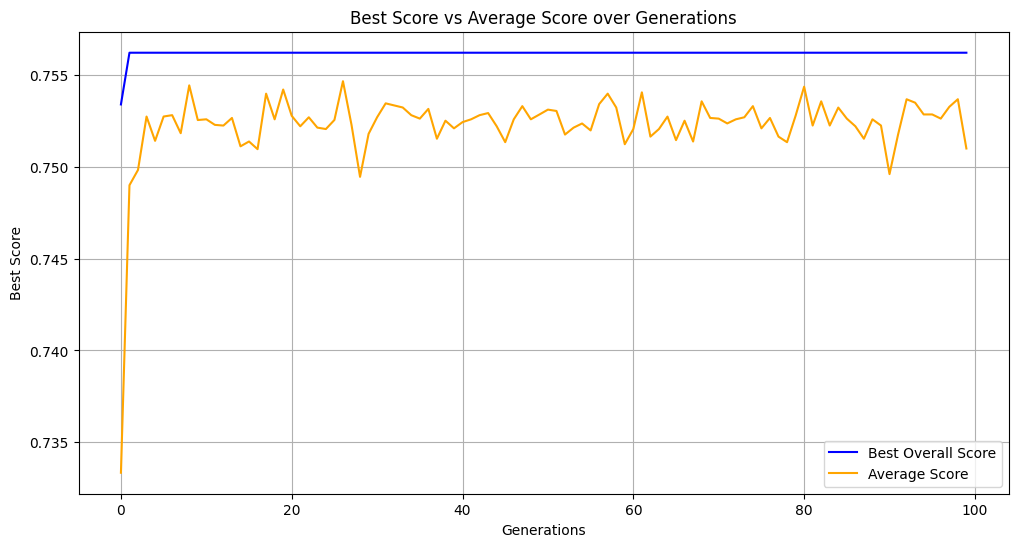

In [75]:
# Creating a graph of best scores over time 
ga_scores = ga_logreg.history_
df = pd.DataFrame(ga_scores)
df

grid_generations = df.shape[0]
plt.figure(figsize=(12, 6))
plt.plot(df['generation'], df['best_score'], label='Best Overall Score', color='blue')
plt.plot(df['generation'], df['avg_score'], label='Average Score', color='orange')
plt.xlabel('Generations')
plt.ylabel('Best Score')
plt.title('Best Score vs Average Score over Generations')
plt.legend()
plt.grid()
plt.show()

##### Grid Search

In [52]:
lr2 = LogisticRegression()
grid_logreg = GridSearchCV(lr2, logreg_param_space2, cv=5, n_jobs=-1, scoring='accuracy')
start10 = time.time()
grid_logreg.fit(X_train_scaled, y_train_binary)
end10 = time.time()
print(f"Grid Search for Logistic Regression took {end10 - start10:.2f} seconds")
print(f"Best parameters from Grid Search for Logistic Regression: {grid_logreg.best_params_}")
print(f"Best score from Grid Search for Logistic Regression: {grid_logreg.best_score_}")

/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Grid Search for Logistic Regression took 46.91 seconds
Best parameters from Grid Search for Logistic Regression: {'C': np.float64(0.012742749857031334), 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Best score from Grid Search for Logistic Regression: 0.7562173038229376


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


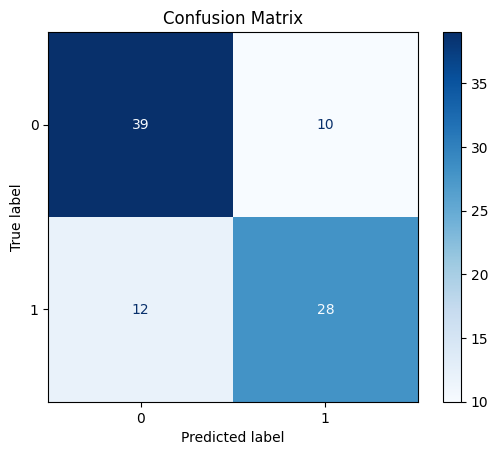

In [53]:
lr2 = grid_logreg.best_estimator_
y_pred2 = lr2.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred2)

##### Randomized Search

In [ ]:
lr3 = LogisticRegression()

accuracies = []
precisions = []
recalls = []
f1s = []

lr3_best_times = []
lr3_best_scores = []

for i in range(50):
    rand_logreg = RandomizedSearchCV(lr3, logreg_param_space2, n_iter=400, cv=5, n_jobs=-1, scoring='accuracy')
    start11 = time.time()
    rand_logreg.fit(X_train_scaled, y_train_binary)
    end11 = time.time()
    
    # save score and time in a list
    lr3_best_scores.append(rand_logreg.best_score_)
    lr3_best_times.append(end11 - start11)
    
    lr3_test = rand_logreg.best_estimator_
    y_pred3 = lr3_test.predict(X_test_scaled)
    acc, prec, rec, f1 = get_analytics(y_test_binary, y_pred3)
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    
# Print the average score and time
print('Randomized Search with Logistic Regression')
print('--------------------------------------------------')
print(f"Average score (train): {np.mean(lr3_best_scores)}")
print(f"Average time (train): {np.mean(lr3_best_times)} seconds")
print('')
print(f"Average accuracy (test): {np.mean(accuracies)}")
print(f"Average precision (test): {np.mean(precisions)}")
print(f"Average recall (test): {np.mean(recalls)}")
print(f"Average f1 (test): {np.mean(f1s)}")

/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Randomized Search with Logistic Regression
--------------------------------------------------
Average score (train): 0.9780219780219781
Average time (train): 2.151095609664917 seconds

Average accuracy (test): 0.9794736842105263
Average precision (test): 0.9795421035020577
Average recall (test): 0.9794736842105263
Average f1 (test): 0.9794713609657403


/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


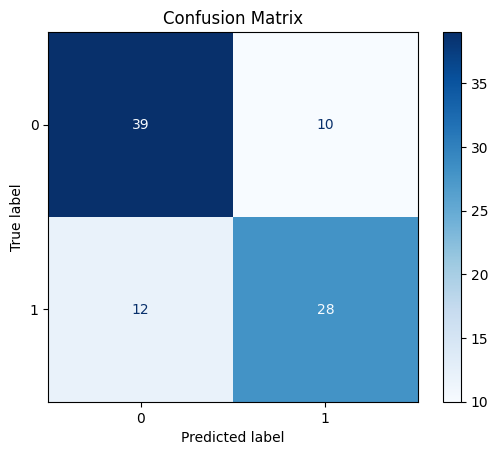

In [105]:
lr3 = rand_logreg.best_estimator_
y_pred3 = lr3.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred3)

##### Halving Grid Search

In [55]:
lr4 = LogisticRegression()
halving_grid_logreg = HalvingGridSearchCV(lr4, logreg_param_space2, cv=5, n_jobs=-1, scoring='accuracy')
start12 = time.time()
halving_grid_logreg.fit(X_train_scaled, y_train_binary)
end12 = time.time()
print(f"Halving Grid Search for Logistic Regression took {end12 - start12:.2f} seconds")
print(f"Best parameters from Halving Grid Search for Logistic Regression: {halving_grid_logreg.best_params_}")
print(f"Best score from Halving Grid Search for Logistic Regression: {halving_grid_logreg.best_score_}")

/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/iansmith/Library/P

Halving Grid Search for Logistic Regression took 45.89 seconds
Best parameters from Halving Grid Search for Logistic Regression: {'C': np.float64(0.03359818286283781), 'class_weight': None, 'fit_intercept': False, 'max_iter': 1700, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-05}
Best score from Halving Grid Search for Logistic Regression: 0.7471428571428571


Accuracy:  0.7528089887640449
Precision:  0.7521828364698925
Recall:  0.7528089887640449
F1 Score:  0.7521117833477383
Classification Report:
{'0': {'precision': 0.7647058823529411, 'recall': 0.7959183673469388, 'f1-score': 0.78, 'support': 49.0}, '1': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 40.0}, 'accuracy': 0.7528089887640449, 'macro avg': {'precision': 0.7507739938080495, 'recall': 0.7479591836734694, 'f1-score': 0.7489743589743589, 'support': 89.0}, 'weighted avg': {'precision': 0.7521828364698925, 'recall': 0.7528089887640449, 'f1-score': 0.7521117833477383, 'support': 89.0}}


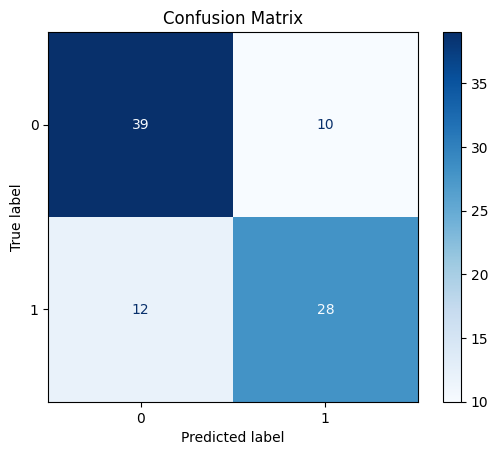

In [108]:
lr4 = halving_grid_logreg.best_estimator_
y_pred4 = lr4.predict(X_test_scaled)
get_analytics(y_test_binary, y_pred4)